In [1]:
#imports 

import pandas as pd
from matplotlib import pyplot as plt
import re
from sklearn import linear_model
import json

In [2]:
#reading wti oil price file

oilprice = pd.read_csv('data/oil_prices.csv')[['Date','Close']].dropna()

oilprice['Date'] = pd.to_datetime(oilprice['Date'])
oilprice = oilprice.replace(to_replace=',', value='', regex=True)
oilprice['Close'] = pd.to_numeric(oilprice['Close'])

In [3]:
#reading ecopetrol stock file

ecostock = pd.read_csv('data/stock_prices.csv')[['Date','Open']]

ecostock['Date'] = pd.to_datetime(ecostock['Date'])
ecostock = ecostock.replace(to_replace=',', value='', regex=True)
ecostock['Open'] = pd.to_numeric(ecostock['Open'])

In [4]:
#reading forex file

forex = pd.read_csv('data/forex.csv')[['Date','Close']].rename(columns={'Date':'Date','Close':'Forex'})
forex['Date'] = pd.to_datetime(forex['Date'])
forex['Forex'] = pd.to_numeric(forex['Forex'])
forex = forex.reindex(index=forex.index[::-1])

In [5]:
#merging files

pricetostock = pd.merge(oilprice,ecostock,how='inner',on='Date').drop(columns=['Date']).rename(columns={'Close':'Oil','Open':'Stock'})


0.5638160071099407


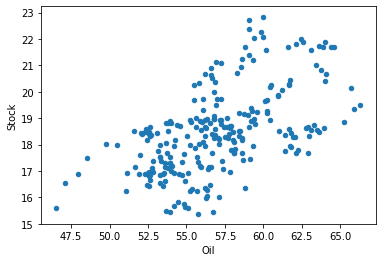

In [6]:
'''The following is an analysis of the relationship between WTI Oil price and Ecopetrol stock price on the same day.'''

print(pricetostock['Oil'].corr(pricetostock['Stock']))
pricetostock.plot.scatter(x='Oil',y='Stock')

In [7]:
#reshaping data

pricetostockshifted = pricetostock.copy()
pricetostockshifted['Stock'] = pricetostockshifted['Stock'].shift(-1)
pricetostockshifted.drop(pricetostockshifted.tail(1).index, inplace=True)

0.518448097877954


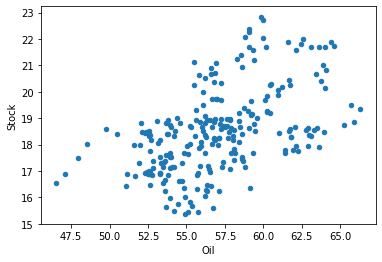

In [8]:
'''The following is an analysis of the relationship between the WTI Oil price in one day and the 
Ecopetrol stock price on the following day'''

print(pricetostockshifted['Oil'].corr(pricetostockshifted['Stock']))
pricetostockshifted.plot.scatter(x='Oil',y='Stock')

In [9]:
#reshaping data

pricetostockdiff = pricetostock.copy().diff()
pricetostockdiff.drop(pricetostockdiff.head(1).index,inplace=True)

0.3258878882870257


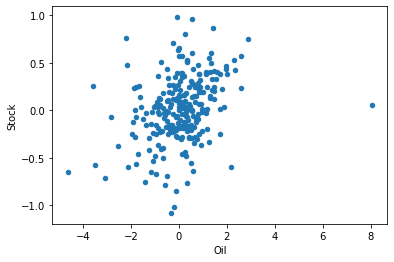

In [10]:
'''The following is an analysis of the relationship between the change in WTI Oil price on a daily interval and the 
change in Ecopetrol stock price on the corresponding dalily interval'''

print(pricetostockdiff['Oil'].corr(pricetostockdiff['Stock']))
pricetostockdiff.plot.scatter(x='Oil',y='Stock')

In [11]:
#reshaping data

pricetostockdiffshifted = pricetostockshifted.copy().diff()
pricetostockdiffshifted.drop(pricetostockdiffshifted.head(1).index, inplace=True)

0.1863046524298469


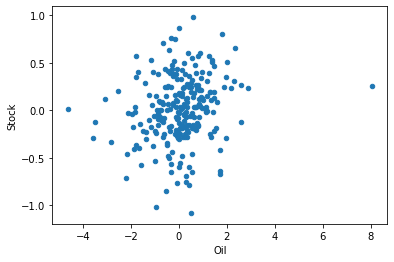

In [12]:
'''The following is an analysis of the relationship between the change in WTI Oil price on a daily interval and the 
change in Ecopetrol stock price on the consecutive dalily interval'''

print(pricetostockdiffshifted['Oil'].corr(pricetostockdiffshifted['Stock']))
pricetostockdiffshifted.plot.scatter(x='Oil',y='Stock')

In [13]:
#reshaping data

pricetostockcorrectshifted = pd.merge(oilprice, ecostock, how='outer', on='Date').shift(-1).dropna().rename(columns={'Close':'Oil','Open':'Stock'})

0.5558597606515226


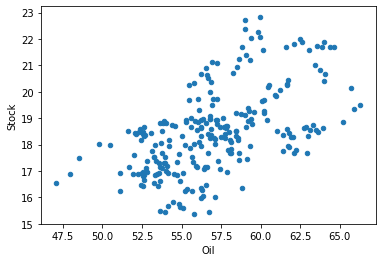

In [14]:
'''The following is an analysis of the relationship between the WTI Oil price in one day and the 
Ecopetrol stock price on the following day. This analysis takes into account updates to the WTI Oil Price that may
have occured in between two Ecopetrol Stock Price updates.'''

print(pricetostockcorrectshifted['Oil'].corr(pricetostockcorrectshifted['Stock']))
pricetostockcorrectshifted.plot.scatter(x='Oil',y='Stock')

In [15]:
#reshaping data

forexpricetostock = pd.merge(forex, pricetostockcorrectshifted, how='outer', on='Date').dropna()
forexpricetostock['Price'] = forexpricetostock['Forex'] * forexpricetostock['Oil']

0.14030836629707444


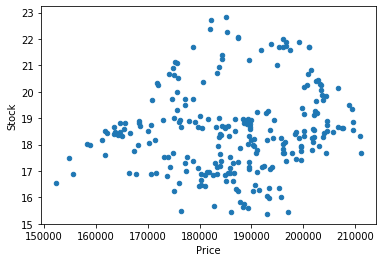

In [16]:
'''The following analysis is exactly the same as the previous one except that the WTI Crude Oil Price is adjusted to
fit its corresponding USD COP exchange rate since mapping these prices to the currency that constitues Ecopetrol
revenue might be more predictive'''

print(forexpricetostock['Price'].corr(forexpricetostock['Stock']))
forexpricetostock.plot.scatter(x='Price',y='Stock')

In [17]:
'''By now, it's safe to say that the most predictive dataset is pricetostockcorrectshifted. Therefore, I will train
and test my model based on this dataset'''

model = linear_model.LinearRegression()

x = pricetostockcorrectshifted.Oil.values
y = pricetostockcorrectshifted.Stock.values

x = x.reshape(len(x), 1)
y = y.reshape(len(y),1)

model = model.fit(x,y)

In [18]:
#saving model

coef = model.coef_[0][0]
inter = model.intercept_[0]

modelObject = {
    'coefficient':coef,
    'intercept':inter
}

with open('model.json', 'w') as modelFile:
    json.dump(modelObject, modelFile)